In [1]:
import torch
import torchvision as tv
import torch.nn as nn

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size=32

transform  = tv.transforms.Compose([tv.transforms.ToTensor()])
train_set = tv.datasets.MNIST(root='/home/yunfei/Desktop/data/MNIST/train', download=True,train=True, transform=transform)
train_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = tv.datasets.MNIST(root='/home/yunfei/Desktop/data/MNIST/test', download=True,train=False, transform=transform)
test_data = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
print(len(train_data))

1875


/home/yunfei/anaconda3/envs/AMAL/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([32, 1, 28, 28])


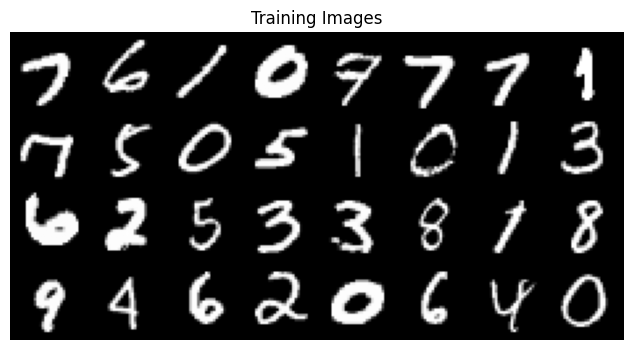

In [3]:
image,_ = next(iter(train_data)) #real_batch est une liste de 2 tenseurs où le 1er correspond aux images, les second correspond aux labels (ici 0 partout)
print(image.shape)
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(image[:64],padding=1,normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:
device=torch.device('cuda')

In [5]:
LATENT_DIM=20

encoder=nn.Sequential(
  nn.Conv2d(1,16,3,2),
  nn.ReLU(),
  nn.Conv2d(16,32,3,2),
  nn.ReLU(),
  nn.Conv2d(32,64,3,1),
  nn.ReLU(),
  nn.Conv2d(64,2*LATENT_DIM,3,2),
  nn.ReLU()
)

decoder=nn.Sequential(
    nn.ConvTranspose2d(LATENT_DIM,32,3,2),
    nn.ReLU(),
    nn.ConvTranspose2d(32,64,3,2),
    nn.ReLU(),
    nn.ConvTranspose2d(64,32,3,2),
    nn.ReLU(),
    nn.ConvTranspose2d(32,1,3,2),
    nn.ReLU(),
    nn.Upsample([28,28]),
    nn.ReLU()
)
encoder=encoder.to(device)
decoder=decoder.to(device)

print(encoder,decoder)



Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 40, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU()
) Sequential(
  (0): ConvTranspose2d(20, 32, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
  (2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (3): ReLU()
  (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (5): ReLU()
  (6): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU()
  (8): Upsample(size=[28, 28], mode=nearest)
  (9): ReLU()
)


In [6]:
LATENT_DIM=20

encoder=nn.Sequential(
   nn.Flatten(start_dim=1),
   nn.Linear(28*28,256),
   nn.ReLU(),
   nn.Linear(256,128),
   nn.ReLU(),
   nn.Linear(128,2*LATENT_DIM)
)

decoder=nn.Sequential(
    nn.Linear(LATENT_DIM,128),
    nn.ReLU(),
    nn.Linear(128,256),
    nn.ReLU(),
    nn.Linear(256,28*28),
    nn.Sigmoid()
)
encoder=encoder.to(device)
decoder=decoder.to(device)

print(encoder,decoder)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=40, bias=True)
) Sequential(
  (0): Linear(in_features=20, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Sigmoid()
)


In [9]:
from torch.distributions import Normal
import torch.optim as optim
import torch.nn.functional as F

def train(max_epochs,train_dataload,test_dataload,encoder,decoder,writer):
    
    optim_model=optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=0.0001)
    iter=0
    train_loss=0
    for epoch in range(max_epochs):
        for x,_ in train_dataload:
            optim_model.zero_grad()
            x=x.to(device)
           
            encode=encoder(x)
            mu,logsig=torch.split(encode,LATENT_DIM,1)
            latent_loss=-0.5*torch.sum(1+logsig-mu.pow(2)-torch.exp(logsig))

            dist=Normal(0,1)
            z=mu+torch.exp(logsig).pow(0.5)*dist.rsample(mu.shape).to(device)
            z=z.view(-1,LATENT_DIM,1,1)
            out=decoder(z).view(-1,28*28)
            reconstruction_loss=F.binary_cross_entropy(out, x.view(-1,28*28), reduction='sum')

            loss=latent_loss+reconstruction_loss
            writer.add_scalar("Loss", loss.item(), iter)
            loss.backward()
            optim_model.step()

            iter+=1
            if iter%100:
                pass
            train_loss+=loss.item()
                            
        train_loss=train_loss/len(train_dataload)
        test_loss=0
        for x,_ in test_dataload:
            with torch.no_grad():
                x=x.to(device)
           
                encode=encoder(x)
                mu,logsig=torch.split(encode,LATENT_DIM,1)
                latent_loss=-0.5*torch.sum(1+logsig-mu.pow(2)-torch.exp(logsig))

                dist=Normal(0,1)
                z=mu+torch.exp(logsig).pow(0.5)*dist.rsample(mu.shape).to(device)
                z=z.view(-1,LATENT_DIM,1,1)
                out=decoder(z).view(-1,28*28)
                reconstruction_loss=F.binary_cross_entropy(out, x.view(-1,28*28), reduction='sum')

                loss=latent_loss+reconstruction_loss
                test_loss+=loss.item()

        test_loss=test_loss/len(test_dataload)

        writer.add_scalar("Test Loss", test_loss, epoch)

        print('EPOCH: [%d/%d]\tTRAIN LOSS: %.4f\t TEST LOSS: %.4f' % (epoch, max_epochs, train_loss, test_loss))

        grid = tv.utils.make_grid(out.view(-1,1,28,28))
        writer.add_image('Images of epoch '+ str(epoch+1), grid)    

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="LATENT_DIM="+str(LATENT_DIM))
max_epochs=20
train(max_epochs,train_data,test_data, encoder.to(device),decoder.to(device),writer)

EPOCH: [0/20]	TRAIN LOSS: 327801.0048	 TEST LOSS: 331921.5693
EPOCH: [1/20]	TRAIN LOSS: 327975.8311	 TEST LOSS: 331921.5693
EPOCH: [2/20]	TRAIN LOSS: 327975.9235	 TEST LOSS: 331921.5693
EPOCH: [3/20]	TRAIN LOSS: 327975.9240	 TEST LOSS: 331921.5693
EPOCH: [4/20]	TRAIN LOSS: 327975.9244	 TEST LOSS: 331921.5693
EPOCH: [5/20]	TRAIN LOSS: 327975.9239	 TEST LOSS: 331921.5693
EPOCH: [6/20]	TRAIN LOSS: 327975.9241	 TEST LOSS: 331921.5693
EPOCH: [7/20]	TRAIN LOSS: 327975.9238	 TEST LOSS: 331921.5693
EPOCH: [8/20]	TRAIN LOSS: 327975.9241	 TEST LOSS: 331921.5693


KeyboardInterrupt: 

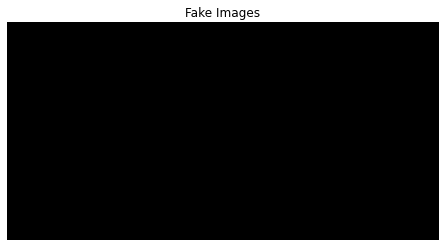

In [12]:

def test(dataload,encoder,decoder):

  for x,_ in dataload:
    x=x.to(device)
    with torch.no_grad():
      encode=encoder(x)
      mu,logsig=torch.split(encode,LATENT_DIM,1)
            
      dist=Normal(0,1)
      z=mu+torch.exp(logsig).pow(0.5)*dist.rsample(mu.shape).to(device)
      z=z.view(-1,LATENT_DIM,1,1)
      out=decoder(z).view(-1,1,28,28)

    img=vutils.make_grid(out, padding=2, normalize=True)
    plt.figure(figsize=(8,4))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img.cpu(),(1,2,0)))
    #plt.savefig( "fake"+str(LATENT_DIM)+".png" )
    break

test(test_data,encoder,decoder)

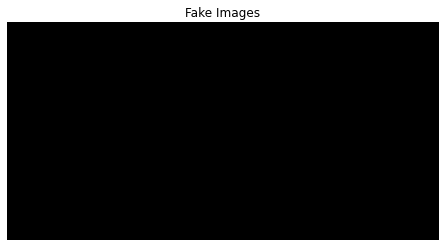

In [13]:
with torch.no_grad():
    z = torch.randn(32, LATENT_DIM).cuda()
    z=z.view(-1,LATENT_DIM,1,1)
    out=decoder(z).view(-1,1,28,28)
    
img=vutils.make_grid(out, padding=2, normalize=True)
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))

In [2]:
%load_ext tensorboard

%tensorboard --logdir runs --host 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18664.